In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%load_ext nb_black
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

<IPython.core.display.Javascript object>

## Load data

In [2]:
dfa = hd.read_analysis_data("XX7")
hd.inspect(dfa)

Time for read_analysis_data            : 4.81 seconds
shape: (91,644, 149), users: 3423


,user_id,ym,txns_count,txns_count_spend,txns_volume,txns_count_sa,txns_count_ca,nunique_tag,nunique_tag_spend,nunique_merchant,pct_credit,month_income_effective,month_income,year_income,income_var,has_month_income,age,is_female,sa_inflows,sa_outflows,sa_netflows,has_sa_inflows,has_reg_sa_inflows,has_benefits,has_pension,has_rent_pmt,has_mortgage_pmt,has_loan_funds,has_loan_repmt,region_name,is_urban,generation,has_od_fees,month_spend,spend_vehicle,spend_cash,spend_groceries,spend_public_transport,spend_phone_and_mobile,spend_bank_charges,spend_household,spend_entertainment,spend_eating_out,spend_entertainment_tv_media,spend_appliances,spend_financial,spend_clothes_and_shoes,spend_home,spend_personal_care,spend_administration,spend_energy_and_water,spend_reading,spend_holidays,spend_taxes,spend_gambling,spend_flowers,spend_gifts,spend_insurance,spend_charity,spend_alcohol,...,count_entertainment,count_eating_out,count_entertainment_tv_media,count_appliances,count_financial,count_clothes_and_shoes,count_home,count_personal_care,count_administration,count_energy_and_water,count_reading,count_holidays,count_taxes,count_gambling,count_flowers,count_gifts,count_insurance,count_charity,count_alcohol,count_legal,count_sports,count_office,count_hobbies,count_flights,count_health_care,count_diy,count_business_expenses,count_housing,count_jewellery,count_taxi,count_loan_repayment,count_mortgage_release,count_garden,count_children,count_pet,count_education,count_vehicle_hire,count_childcare,count_art,count_accessories,count_fines,entropy_tag,entropy_tag_z,entropy_tag_s,entropy_tag_sz,std_tag,entropy_tag_spend,entropy_tag_spend_z,entropy_tag_spend_s,entropy_tag_spend_sz,std_tag_spend,entropy_merchant,entropy_merchant_z,entropy_merchant_s,entropy_merchant_sz,std_merchant,entropy_groc,entropy_groc_z,entropy_groc_s,entropy_groc_sz
0,37,2012-04,17.0,8,5654.799805,1.0,9.0,3,5,3,4.855317,0.44000,1.564053,18.768633,0.623895,1,27.0,0.0,0.0,1500.0,-1500.0,0,0,0,0,0,1,0,0,scotland,0.0,Millennials,0,1.20816,0.0,0.62331,0.17861,0.0,0.00,0.0,0.00798,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561278,-0.979345,2.866587,1.014205,1.364225,2.155639,-0.875887,5.440362,1.432497,0.564113,1.584963,-1.815369,10.083279,0.911932,0.052510,0.000000,-2.076207,4.297079,1.142271
1,37,2012-05,20.0,14,5678.870117,1.0,13.0,4,5,5,14.387589,1.30853,1.564053,18.768633,0.523057,1,27.0,0.0,2848.5,0.0,2848.5,1,0,0,0,0,1,0,0,scotland,0.0,Millennials,0,0.62401,0.0,0.05324,0.13341,0.0,0.05,0.0,0.00000,0.0,0.0,0.03978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.664498,-0.792623,2.662954,0.250701,2.603417,1.921185,-1.173707,5.262624,0.970552,1.140459,1.780672,-1.624232,10.069009,0.679353,0.226916,0.591673,-1.333431,3.952981,-0.196891


<IPython.core.display.Javascript object>

## Correlations of e and es with components

Calculate entropies and components

We can decompose smoothed entropy as

$$es = -\sum_{cat > 0}\frac{f_i + 1}{N + Cz + Cnz}log(\frac{f_i + 1}{N + Cz + Cnz}) - Cz \times \frac{1}{N + Cz + Cnz}log(\frac{1}{N + Cz + Cnz}),$$

where $N$ is number of transactions, and $Cz$ and $Cnz$ are number of categories with zero and non-zero counts, respectively. Below, I refer to lhs as A and to rhs as B.

In [4]:
# Create entropy components
df = pd.DataFrame()
counts = dfa.filter(regex="user_id|^ym|^count_").set_index(["user_id", "ym"])
df["N"] = counts.sum(1)
df["Cz"] = counts.eq(0).sum(1)
df["Cnz"] = counts.gt(0).sum(1)
df["counts_std_all"] = counts.std(1)
df["counts_std_nz"] = counts[counts > 0].std(1)
# df["counts_iqr"] = counts.quantile(0.75, axis=1) - counts.quantile(0.25, axis=1)
denom = df.N + df.Cz + df.Cnz
probs = (counts > 0) * (counts + 1).div(denom, axis=0)
df["A"] = -probs.mul(np.log2(probs)).fillna(0).sum(1)
const = -(1 / denom) * np.log2(1 / denom)
df["B"] = df.Cz * const

# # Create dataset with components and entropy from analysis data
entropy_data = dfa.filter(regex="user_id|^ym|entropy_tag_spend(?!.*z)|has_sa_inflows")
df = entropy_data.merge(df.reset_index(), how="left", validate="1:1")
df = df.set_index(["user_id", "ym"])

# # # Consistency checks
assert len(counts.columns) == 48
assert all(df.Cz + df.Cnz == len(counts.columns))

<IPython.core.display.Javascript object>

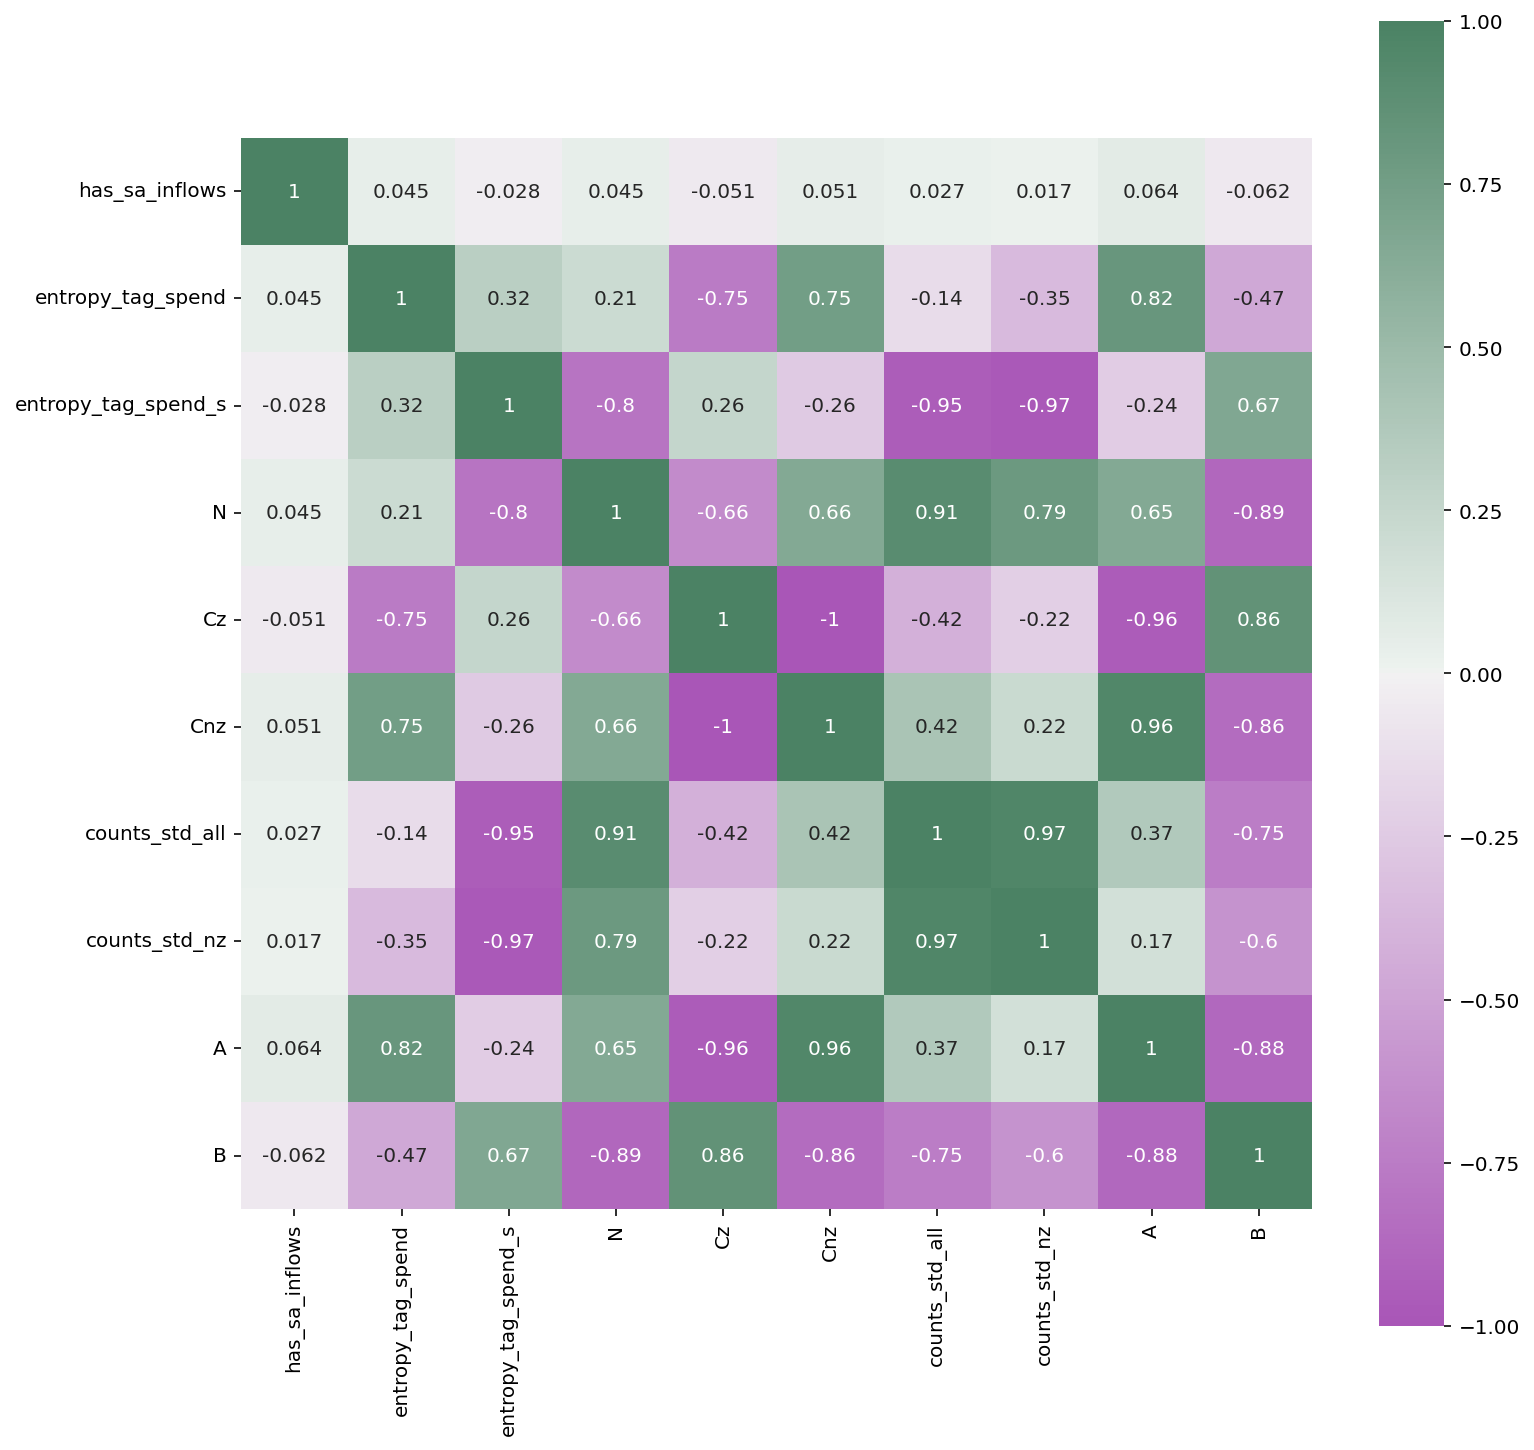

<IPython.core.display.Javascript object>

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
mask = None
cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True)
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap=cmap);

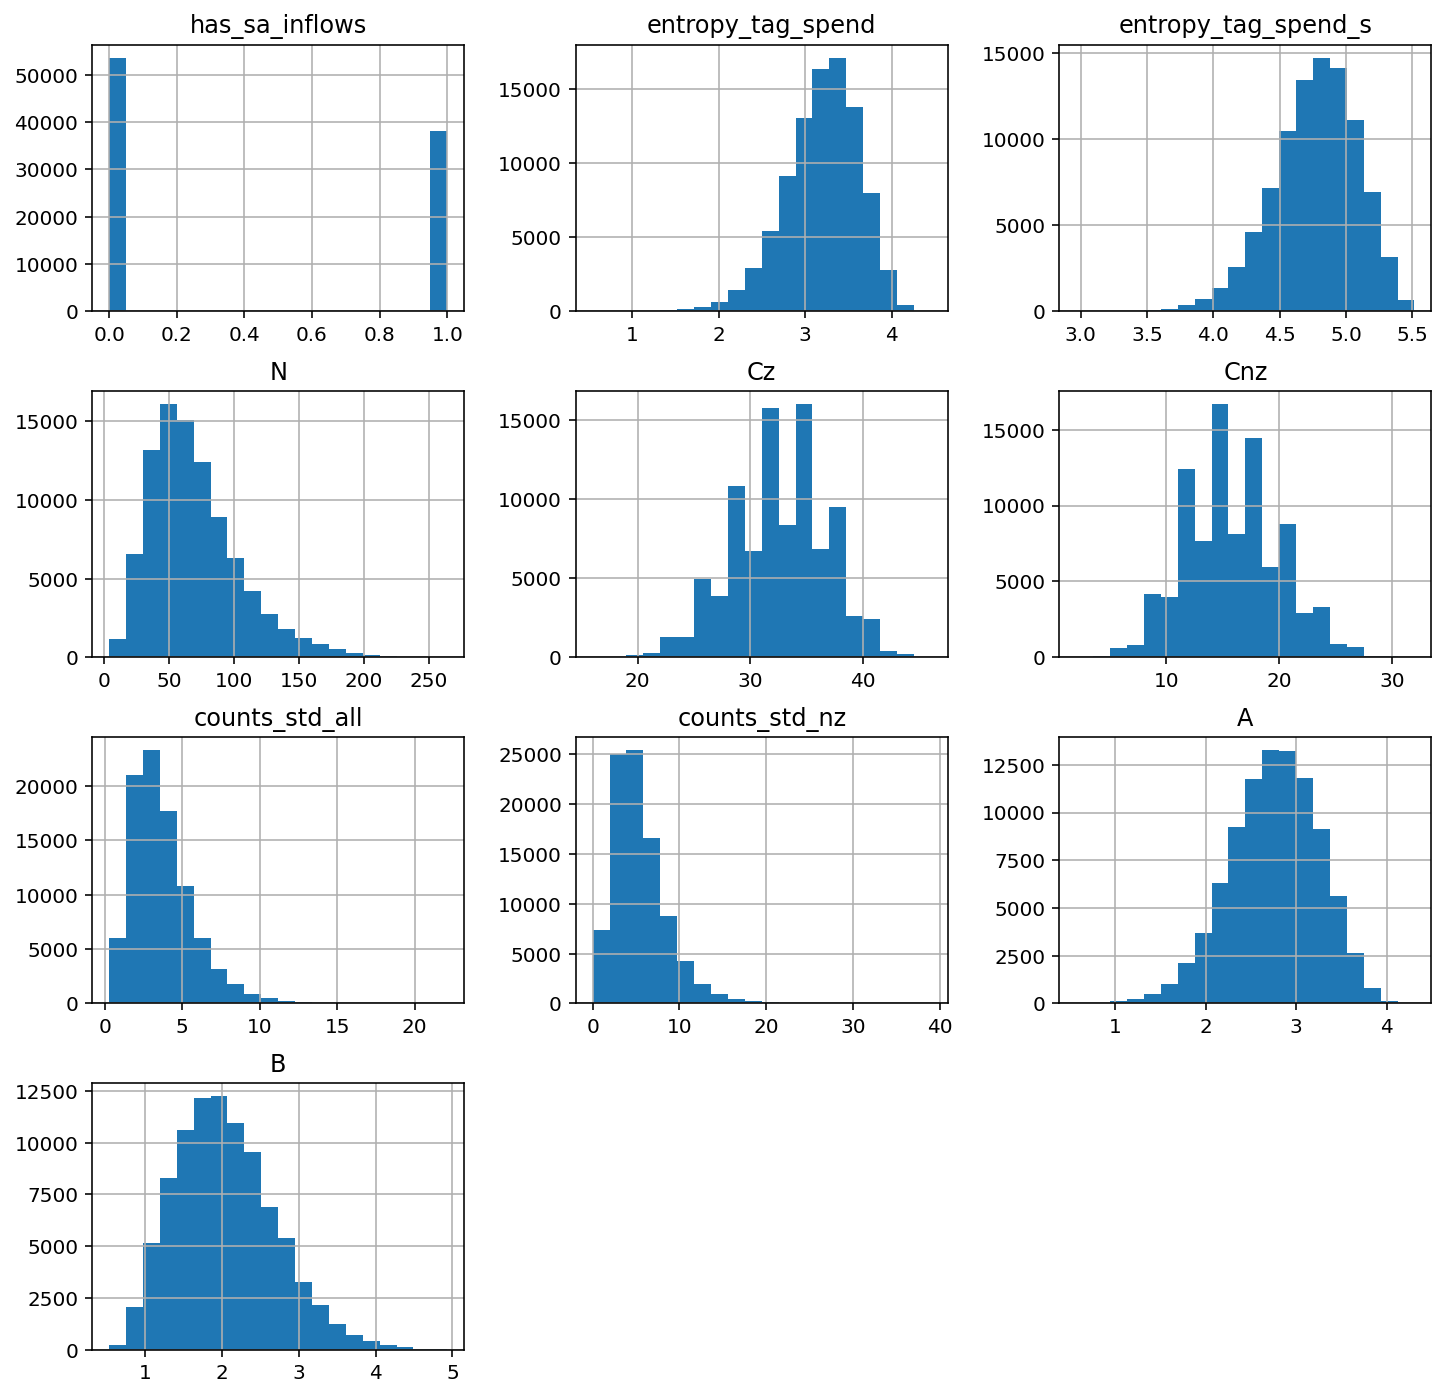

In [6]:
df.hist(figsize=(12, 12), bins=20);

In [153]:
df.describe()

,has_sa_inflows,entropy_tag_spend,entropy_tag_spend_s,N,Cz,Cnz,counts_std_all,counts_std_nz,A,B
count,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000,91644.000000
mean,0.414986,3.199797,4.769010,69.144003,32.385077,15.614923,3.709798,5.454538,2.756959,2.042527
std,0.492722,0.423274,0.314902,34.465551,4.155630,4.155630,1.998448,3.144692,0.490338,0.645199
min,0.000000,0.543564,2.966448,4.000000,16.000000,2.000000,0.279310,0.000000,0.572742,0.532957
25%,0.000000,2.939284,4.571990,44.000000,30.000000,13.000000,2.276927,3.229290,2.433924,1.566528
50%,0.000000,3.238899,4.793783,63.000000,33.000000,15.000000,3.317427,4.847151,2.779317,1.982301
75%,1.000000,3.501776,4.995424,87.000000,35.000000,18.000000,4.696035,6.985630,3.110279,2.452478
max,1.000000,4.452932,5.515563,264.000000,46.000000,32.000000,22.096731,38.988093,4.307258,4.933073


## Stylised facts:

- Entropy is mainly driven by the number of non-zero counts and the total number of txns. The fact that it's not strongly correlated with counts variation suggests counts don't vary a lot.

- Smooth entropy is mainly driven by the variation in counts.

## 3d view of smooth entropy and components correlation

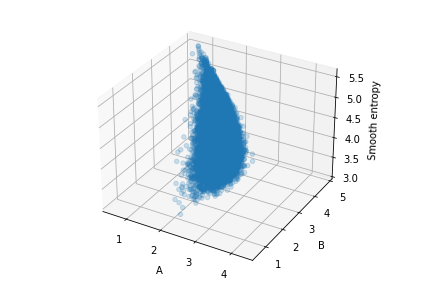

In [147]:
%matplotlib widget
from mpl_toolkits.mplot3d import axes3d

sample = 0.2

d = df.sample(frac=sample)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(d.A, d.B, d.entropy_tag_spend_s, alpha=0.2)
ax.set(xlabel="A", ylabel="B", zlabel="Smooth entropy")
plt.tight_layout()

## Explaining model 3

### Within vs between variation

In [30]:
g = df.groupby("user_id")

b = g.mean().std().rename("between")
w = g.std().mean().rename("within")
bw = (bw / wi).rename("b/w")

pd.concat([b, w, bw], axis=1)

,between,within,b/w
has_sa_inflows,0.323169,0.345163,0.936281
entropy_tag_spend,0.334295,0.264296,1.264853
entropy_tag_spend_s,0.244958,0.193055,1.268852
N,27.451205,18.541962,1.480491
Cz,3.383625,2.419838,1.398286
Cnz,3.383625,2.419838,1.398286
counts_std_all,1.537008,1.115754,1.377551
counts_std_nz,2.391193,1.829269,1.307185
A,0.400690,0.291092,1.376507
B,0.525868,0.381250,1.379327


## Explaining results

Overall finding is that users 1) with a higher number of total spend txns, 2) who spend more diversely, and 3) spend more unequally across categories tend to save more.

### Do we lack proper data for low entropy users?

High entropy correlates most strongly with the number of zero counts and the total number of spend transactions, and is also positively correlated with a savings transaction. One possibility is that this an artifact of our data: if we don't observe the full transaction history for some users (e.g. because they don't link all their accounts), then these users will tend to have lower entropy and we are less likely to observe a savings transaction.

If this were true, then we'd expect to observe implausibly few spend txns and positive spend categories for low entropy users, as well as possibly much shorter observation periods.

The below shows that this is not the case.

In [46]:
def low_entropy_users(df, pct=10):
    """List of users with average spend tag entropy below pct percentile."""

    entropy_user_mean = df.groupby("user_id").entropy_tag_spend.mean()
    entropy_pct = np.percentile(entropy_user_mean, pct)
    return (entropy_user_mean < entropy_pct).rename("low_entropy_user")


is_low_entropy = low_entropy_users(dfa)

<IPython.core.display.Javascript object>

In [58]:
dfa.groupby("user_id").agg(
    mean_num_txns=("txns_count_spend", "mean"),
    mean_num_cat=("nunique_tag_spend", "mean"),
    mean_num_months=("ym", "nunique"),
).groupby(is_low_entropy).describe().T

low_entropy_user             False        True
mean_num_txns   count  3080.000000  343.000000
                mean     68.229647   57.672324
                std      27.535622   24.766923
                min      13.777778    9.857143
                25%      48.039474   40.923611
                50%      63.072751   53.888889
                75%      83.470307   72.639860
                max     187.600000  164.611111
mean_num_cat    count  3080.000000  343.000000
                mean     15.794319   10.924586
                std       3.144593    2.032394
                min       8.500000    5.954545
                25%      13.368421    9.697288
                50%      15.500000   10.857143
                75%      17.885013   12.222222
                max      27.916667   17.864865
mean_num_months count  3080.000000  343.000000
                mean     27.252597   22.466472
                std      16.402353   13.909835
                min       6.000000    6.000000
                25%      14.000000   11.000000
                50%      23.000000   18.000000
                75%      37.000000   32.000000
                max      96.000000   93.000000

<IPython.core.display.Javascript object>

## Make Neil data

In [4]:
# Create entropy components
df = pd.DataFrame()
counts = dfa.filter(regex="user_id|^ym|^count_").set_index(["user_id", "ym"])
df["N"] = counts.sum(1)
df["Cz"] = counts.eq(0).sum(1)
df["Cnz"] = counts.gt(0).sum(1)
df["counts_std_all"] = counts.std(1)
df["counts_std_nz"] = counts[counts > 0].std(1)
# df["counts_iqr"] = counts.quantile(0.75, axis=1) - counts.quantile(0.25, axis=1)
denom = df.N + df.Cz + df.Cnz
probs = (counts > 0) * (counts + 1).div(denom, axis=0)
df["A"] = -probs.mul(np.log2(probs)).fillna(0).sum(1)
const = -(1 / denom) * np.log2(1 / denom)
df["B"] = df.Cz * const

# # Create dataset with components and entropy from analysis data
df = df.reset_index().merge(dfa, how="right", validate="1:1")
df = df.set_index(["user_id", "ym"])

# # # Consistency checks
assert len(counts.columns) == 48
assert all(df.Cz + df.Cnz == len(counts.columns))
pd.testing.assert_series_equal(
    df.N.astype("int"), df.txns_count_spend, check_names=False
)
pd.testing.assert_series_equal(df.Cnz, df.nunique_tag_spend, check_names=False)


first = [
    "N",
    "Cz",
    "Cnz",
    "counts_std_all",
    "counts_std_nz",
    "A",
    "B",
    "entropy_tag_spend_z",
    "entropy_tag_spend_sz",
]

fp = "/Users/fgu/entropy_data.csv"
hd.order_columns(df, first, others_alpha=False).reset_index().to_csv(fp, index=False)

<IPython.core.display.Javascript object>

In [8]:
df = pd.read_csv(fp)
hd.inspect(df)

shape: (91,644, 156), users: 3423


,user_id,ym,N,Cz,Cnz,counts_std_all,counts_std_nz,A,B,entropy_tag_spend_z,entropy_tag_spend_sz,txns_count,txns_count_spend,txns_volume,txns_count_sa,txns_count_ca,nunique_tag,nunique_tag_spend,nunique_merchant,pct_credit,month_income_effective,month_income,year_income,income_var,has_month_income,age,is_female,sa_inflows,sa_outflows,sa_netflows,has_sa_inflows,has_reg_sa_inflows,has_benefits,has_pension,has_rent_pmt,has_mortgage_pmt,has_loan_funds,has_loan_repmt,region_name,is_urban,generation,has_od_fees,month_spend,spend_vehicle,spend_cash,spend_groceries,spend_public_transport,spend_phone_and_mobile,spend_bank_charges,spend_household,spend_entertainment,spend_eating_out,spend_entertainment_tv_media,spend_appliances,spend_financial,spend_clothes_and_shoes,spend_home,spend_personal_care,spend_administration,spend_energy_and_water,...,count_bank_charges,count_household,count_entertainment,count_eating_out,count_entertainment_tv_media,count_appliances,count_financial,count_clothes_and_shoes,count_home,count_personal_care,count_administration,count_energy_and_water,count_reading,count_holidays,count_taxes,count_gambling,count_flowers,count_gifts,count_insurance,count_charity,count_alcohol,count_legal,count_sports,count_office,count_hobbies,count_flights,count_health_care,count_diy,count_business_expenses,count_housing,count_jewellery,count_taxi,count_loan_repayment,count_mortgage_release,count_garden,count_children,count_pet,count_education,count_vehicle_hire,count_childcare,count_art,count_accessories,count_fines,entropy_tag,entropy_tag_z,entropy_tag_s,entropy_tag_sz,std_tag,entropy_tag_spend,entropy_tag_spend_s,std_tag_spend,entropy_merchant,entropy_merchant_z,entropy_merchant_s,entropy_merchant_sz,std_merchant,entropy_groc,entropy_groc_z,entropy_groc_s,entropy_groc_sz
0,37,2012-04,8.0,43,5,0.55862,0.894427,1.013227,4.459219,-0.875887,1.432497,17.0,8,5654.80,1.0,9.0,3,5,3,4.855317,0.44000,1.564053,18.768633,0.623895,1,27.0,0.0,0.0,1500.0,-1500.0,0,0,0,0,0,1,0,0,scotland,0.0,Millennials,0,1.20816,0.0,0.62331,0.17861,0.0,0.00,0.0,0.00798,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561278,-0.979345,2.866587,1.014205,1.364225,2.155639,5.440362,0.564113,1.584963,-1.815369,10.083279,0.911932,0.052510,0.000000,-2.076207,4.297079,1.142271
1,37,2012-05,14.0,43,5,1.12908,2.489980,1.167336,4.129523,-1.173707,0.970552,20.0,14,5678.87,1.0,13.0,4,5,5,14.387589,1.30853,1.564053,18.768633,0.523057,1,27.0,0.0,2848.5,0.0,2848.5,1,0,0,0,0,1,0,0,scotland,0.0,Millennials,0,0.62401,0.0,0.05324,0.13341,0.0,0.05,0.0,0.00000,0.0,0.0,0.03978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.664498,-0.792623,2.662954,0.250701,2.603417,1.921185,5.262624,1.140459,1.780672,-1.624232,10.069009,0.679353,0.226916,0.591673,-1.333431,3.952981,-0.196891


<IPython.core.display.Javascript object>